In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #plotting graphs
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['djia-data', 'data-for-train', 'sentiment-analysis-data']


In [2]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, brown
from sklearn.metrics import recall_score, f1_score, accuracy_score, confusion_matrix, precision_score

The data set is having 3 classes with i.e. positive >2, negative>0 and neutral>1m

In [3]:
dataset = pd.read_csv('../input/sentiment-analysis-data/training_data.csv')
dataset.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)

In [4]:
extra_data = pd.read_csv('../input/data-for-train/X_train2.csv')
extra_data.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)
dataset = pd.concat([dataset, extra_data], axis = 0, ignore_index= True, verify_integrity=True)

In [5]:
dataset.head()

,text,label
0,RT @XHNews: Jack Ma of China's Alibaba Group j...,2
1,Jack Ma of China's Alibaba Group joins UN Secr...,2
2,Jack Ma of China's Alibaba Group joins UN Secr...,2
3,IAM Platform Curated Tweet\n\nHamilton Lane Ad...,2
4,RT @IrishTimesBiz: Alibaba picks CICC and Suis...,1


In [6]:
value_freq = dataset['label'].value_counts()
print(value_freq)

1    1996
2    1399
0     909
Name: label, dtype: int64


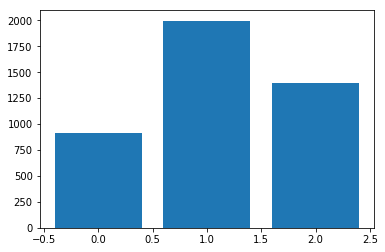

In [7]:
aux = plt.bar(x = [1,2,0], height = value_freq, )
plt.show()

In [8]:
# removing stopword from each row of the dataset
def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [9]:
corpus = []
for i in range(dataset.shape[0]):
    corpus.append(preprocess(dataset['text'][i]))

### Creating bag of words

In [10]:
#file = open('../input/bag_of_words.txt')
#bag_of_words = file.read().split(' ')
#file.close()

In [11]:
#creating a bag of words of 1000 most frequently occuring word and then converting data to array on its basis.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tf = TfidfVectorizer(ngram_range = (1,2), stop_words= ['http', 'appl','aapl', 'co', 'tweet', 'rt','amp', 'iphon'], max_features = 1500)

In [12]:
# fitting and creating the transformation of corpus to array
tf.fit(set(corpus))
X = tf.transform(corpus).toarray()
y = dataset['label'].values

# Creating word cloud

In [13]:
bag_of_words = tf.get_feature_names()

In [14]:
pos_tweet = X[y == 2]
neu_tweet = X[y == 1]
neg_tweet = X[y == 0]

In [15]:
#creating word cloud for positive, neutral and negtive tweets
words_count_positive = {}
words_count_neutral = {}
words_count_negative = {}

i = 0
while i <X.shape[1]:
    words_count_positive[bag_of_words[i]] = np.sum(pos_tweet[:,i])
    words_count_neutral[bag_of_words[i]] = np.sum(neu_tweet[:,i])
    words_count_negative[bag_of_words[i]] = np.sum(neg_tweet[:,i])
    
    i = i+1

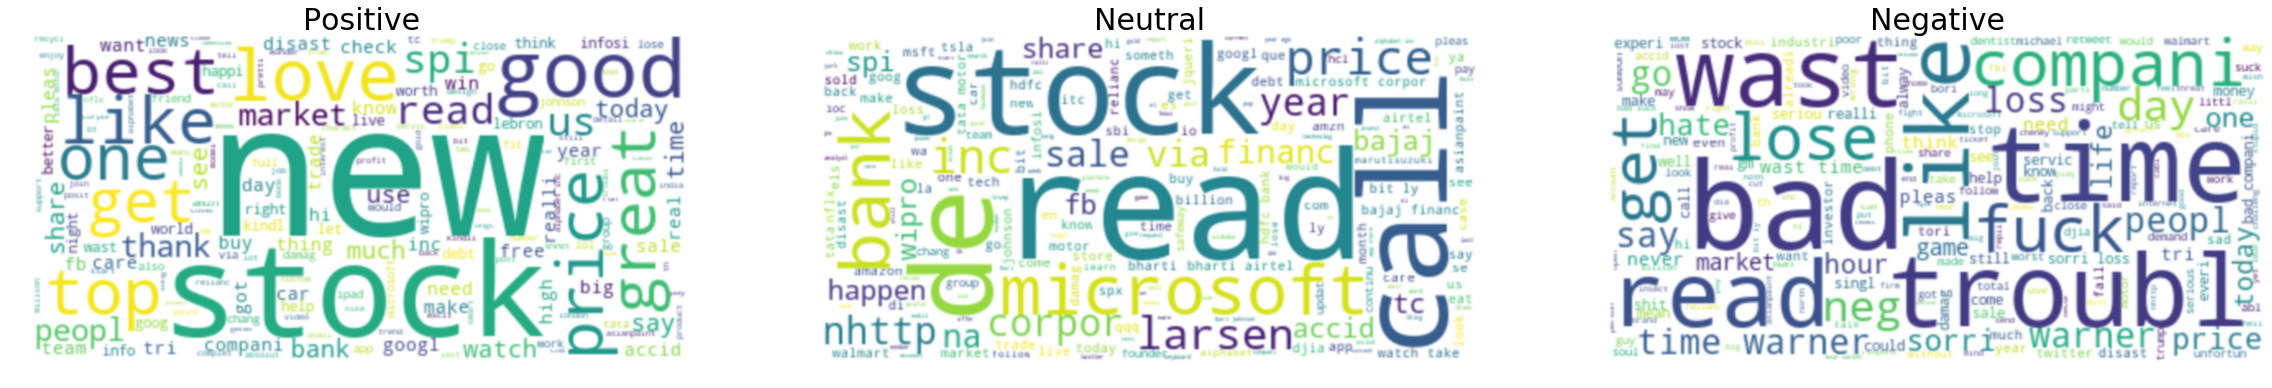

In [16]:
from wordcloud import WordCloud
wc_pos = WordCloud(background_color= 'white').generate_from_frequencies(words_count_positive)
wc_neu = WordCloud(background_color= 'white').generate_from_frequencies(words_count_neutral)
wc_neg = WordCloud(background_color= 'white').generate_from_frequencies(words_count_negative)

plt.figure(figsize = (40,50))

plt.subplot('131')
plt.title('Positive',fontsize = 30)
plt.imshow(wc_pos, interpolation="bicubic")
plt.axis("off")

plt.subplot('132')
plt.title('Neutral',fontsize = 30)
plt.imshow(wc_neu, interpolation="bicubic")
plt.axis("off")

plt.subplot('133')
plt.title('Negative',fontsize = 30)
plt.imshow(wc_neg, interpolation="bicubic")
plt.axis("off")

plt.show()

# Splitting the data X and Y in training and test set

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.15, random_state = 32)

### Fuction to show the accuracy, f1 score, recall and precision , also plotting the graph of frequency of 3 classes of tweets for true and prediction

In [18]:
def model_info_train(classifier, data_X, data_Y, name):
    # training set
    print("****training_set****")
    print("Model is <<"+name+">>")
    data_Y_pred = classifier.predict(data_X)
    print("accuracy:",accuracy_score(data_Y, data_Y_pred))
    print("f1 score:", f1_score(data_Y,data_Y_pred, average = "macro")) # unweighted mean,i.e. does not take label imbalance in account
    print("recall:", recall_score(data_Y,data_Y_pred, average= "macro"))
    print("precision:", precision_score(data_Y, data_Y_pred, average = "macro"))
    
    # plotting
    plt.figure(figsize = (10,4))
    ax1 = plt.subplot('121', )
    plt.title("X_train")
    train_freq = {}
    train_freq['positive'] = np.sum((data_Y == 2)*1)
    train_freq['neutral'] = np.sum((data_Y == 1)*1)
    train_freq['negative'] = np.sum((data_Y == 0)*1)
    
    lists = sorted(train_freq.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    plt.bar(x, y)
    
    plt.subplot('122', sharex = ax1, sharey = ax1)
    plt.title("X_train predict")
    train_pred_freq = {}
    train_pred_freq['positive'] = np.sum((data_Y_pred == 2)*1)
    train_pred_freq['neutral'] = np.sum((data_Y_pred == 1)*1)
    train_pred_freq['negative'] = np.sum((data_Y_pred == 0)*1)
    
    lists = sorted(train_pred_freq.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    plt.bar(x, y)
    
    

In [19]:
def model_info_validation(classifier, data_X, data_Y, name):
    # validate set
    print("****validate_set****")
    print("Model is <<"+name+">>")
    data_Y_pred = classifier.predict(data_X)
    print("accuracy:",accuracy_score(data_Y, data_Y_pred))
    print("f1 score:", f1_score(data_Y,data_Y_pred, average = "macro")) # unweighted mean,i.e. does not take label imbalance in account
    print("recall:", recall_score(data_Y,data_Y_pred, average= "macro"))
    print("precision:", precision_score(data_Y, data_Y_pred, average = "macro"))
    
    # plotting
    plt.figure(figsize = (10,4))
    ax1 = plt.subplot('121')
    plt.title("X_validate")
    validate_freq = {}
    validate_freq['positive'] = np.sum((data_Y == 2)*1)
    validate_freq['neutral'] = np.sum((data_Y == 1)*1)
    validate_freq['negative'] = np.sum((data_Y == 0)*1)
   
    lists = sorted(validate_freq.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    plt.bar(x, y)
    
    plt.subplot('122', sharex = ax1, sharey = ax1)
    plt.title("X_validate predict")
    validate_pred_freq = {}
    validate_pred_freq['positive'] = np.sum((data_Y_pred == 2)*1)
    validate_pred_freq['neutral'] = np.sum((data_Y_pred == 1)*1)
    validate_pred_freq['negative'] = np.sum((data_Y_pred == 0)*1)
    
    lists = sorted(validate_pred_freq.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    plt.bar(x, y)

In [20]:
def model_info_test(classifier, data_X, data_Y, name):
    # test set
    print("****test_set****")
    print("Model is <<"+name+">>")
    data_Y_pred = classifier.predict(data_X)
    print("accuracy:",accuracy_score(data_Y, data_Y_pred))
    print("f1 score:", f1_score(data_Y,data_Y_pred, average = "macro")) # unweighted mean,i.e. does not take label imbalance in account
    print("recall:", recall_score(data_Y,data_Y_pred, average= "macro"))
    print("precision:", precision_score(data_Y, data_Y_pred, average = "macro"))
    
    # plotting
    plt.figure(figsize = (10,4))
    ax1 = plt.subplot('121')
    plt.title("X_test")
    test_freq = {}
    test_freq['positive'] = np.sum((data_Y == 2)*1)
    test_freq['neutral'] = np.sum((data_Y == 1)*1)
    test_freq['negative'] = np.sum((data_Y == 0)*1)
    lists = sorted(test_freq.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    plt.bar(x, y)
    
    plt.subplot('122', sharex = ax1, sharey = ax1)
    plt.title("X_test predict")
    test_pred_freq = {}
    test_pred_freq['positive'] = np.sum((data_Y_pred == 2)*1)
    test_pred_freq['neutral'] = np.sum((data_Y_pred == 1)*1)
    test_pred_freq['negative'] = np.sum((data_Y_pred == 0)*1)
    lists = sorted(test_pred_freq.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    plt.bar(x, y)

# Naive Bayes Classifier

In [21]:
from sklearn.naive_bayes import MultinomialNB
classifier_naive_bayes = MultinomialNB(fit_prior = False)
classifier_naive_bayes.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

****training_set****
Model is <<Naive Bayes Classifier>>
accuracy: 0.7646254784034991
f1 score: 0.758831362836527
recall: 0.7835795652032419
precision: 0.755614677510014


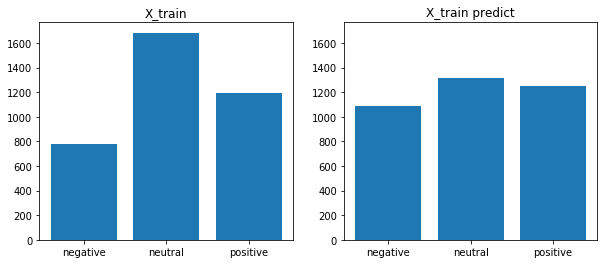

In [22]:
model_info_train(classifier_naive_bayes, X_train, y_train, 'Naive Bayes Classifier')


****validate_set****
Model is <<Naive Bayes Classifier>>
accuracy: 0.6640866873065016
f1 score: 0.6541830108750991
recall: 0.6837311110141512
precision: 0.6592441113919988


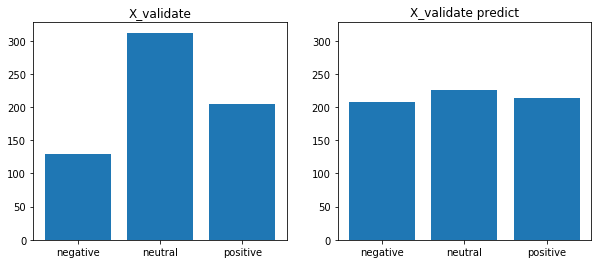

In [23]:
model_info_validation(classifier_naive_bayes, X_test, y_test, 'Naive Bayes Classifier')

# Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
lg_classifier = LogisticRegression(random_state = 0, max_iter = 10000, solver = 'saga', multi_class = 'multinomial', warm_start = True, n_jobs = -1)
lg_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=True)

****training_set****
Model is <<Logistic Regression>>
accuracy: 0.8542919628212138
f1 score: 0.837703011503665
recall: 0.8194408406406639
precision: 0.8718310461047141


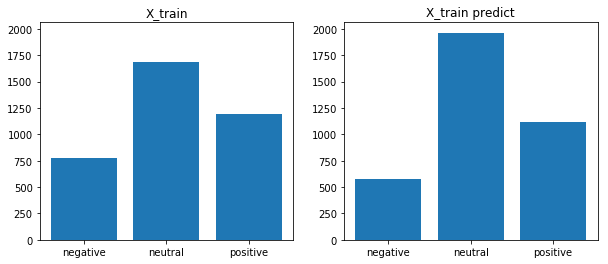

In [25]:
model_info_train(lg_classifier, X_train, y_train, 'Logistic Regression')

****validate_set****
Model is <<Logistic Regression>>
accuracy: 0.7678018575851393
f1 score: 0.735966502460014
recall: 0.7174222261006152
precision: 0.7738946493663476


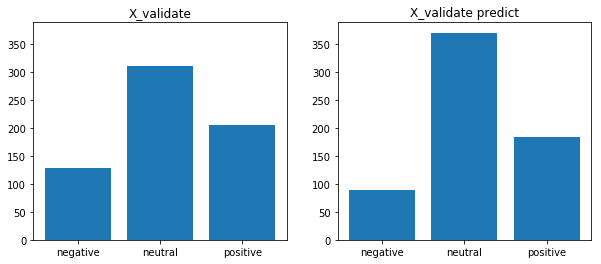

In [26]:
model_info_validation(lg_classifier, X_test, y_test, 'Logistic Regression')

# SVM

In [27]:
from sklearn.svm import SVC
svc_classifier = SVC(kernel = 'linear', random_state = 32, coef0 = 0, gamma = 'auto')
svc_classifier.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=32, shrinking=True, tol=0.001,
    verbose=False)

****training_set****
Model is <<Support Vector Machine>>
accuracy: 0.8611262985237835
f1 score: 0.8469043728965016
recall: 0.8323231715758483
precision: 0.8704444312710402


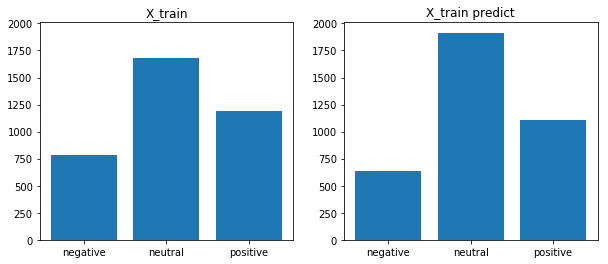

In [28]:
model_info_train(svc_classifier, X_train, y_train, 'Support Vector Machine')

****validate_set****
Model is <<Support Vector Machine>>
accuracy: 0.7492260061919505
f1 score: 0.7189179686578986
recall: 0.7086765711127595
precision: 0.7359378753908746


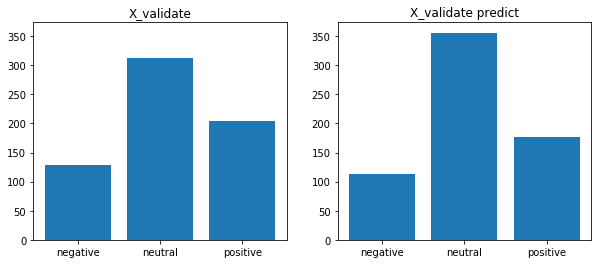

In [29]:
model_info_validation(svc_classifier, X_test, y_test, 'Support Vector Machine')

# Decision Tree Classification

In [30]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state  = 32)
dt_classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=32, splitter='best')

****training_set****
Model is <<Decision Tree Classification>>
accuracy: 0.9956260251503554
f1 score: 0.9956221497796719
recall: 0.9951842112484995
precision: 0.9960725763621419


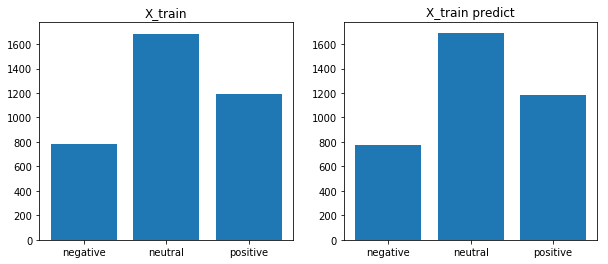

In [31]:
model_info_train(dt_classifier, X_train, y_train, 'Decision Tree Classification')

****validate_set****
Model is <<Decision Tree Classification>>
accuracy: 0.760061919504644
f1 score: 0.7425634871008234
recall: 0.7468535324888133
precision: 0.7390129535415534


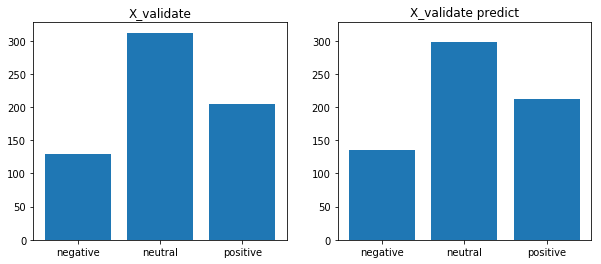

In [32]:
model_info_validation(dt_classifier, X_test, y_test, 'Decision Tree Classification')

# Random Forest Classification

In [33]:
from sklearn.ensemble import RandomForestClassifier
rdt_classifier = RandomForestClassifier(n_estimators=10, criterion='entropy',
                                   n_jobs = -1, random_state = 32)
rdt_classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

****training_set****
Model is <<Random Forest Classification>>
accuracy: 0.985784581738655
f1 score: 0.9851809184434835
recall: 0.982954171348041
precision: 0.9875303435461599


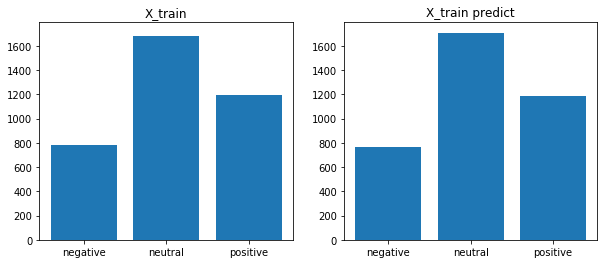

In [34]:
model_info_train(rdt_classifier, X_train, y_train, 'Random Forest Classification')

****validate_set****
Model is <<Random Forest Classification>>
accuracy: 0.781733746130031
f1 score: 0.7528509348460476
recall: 0.7405207227385334
precision: 0.7740129148548279


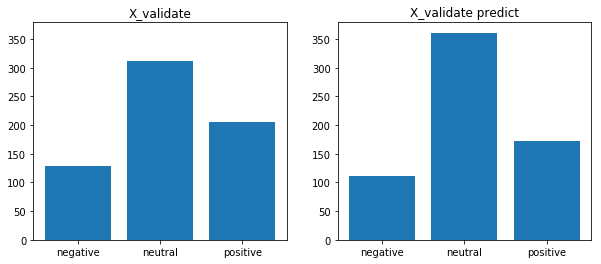

In [35]:
model_info_validation(rdt_classifier, X_test, y_test, 'Random Forest Classification')

# Stochastic Gradient Descent Classifier

In [36]:
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier(max_iter = 10000, n_jobs = -1, random_state = 32, tol = 0.00001,early_stopping = True)
sgd_classifier.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=10000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=32, shuffle=True, tol=1e-05,
              validation_fraction=0.1, verbose=0, warm_start=False)

****training_set****
Model is <<Stochastic Gradient Descent Classification>>
accuracy: 0.8895571350464735
f1 score: 0.8815956218004158
recall: 0.8785629071112306
precision: 0.8862852923596217


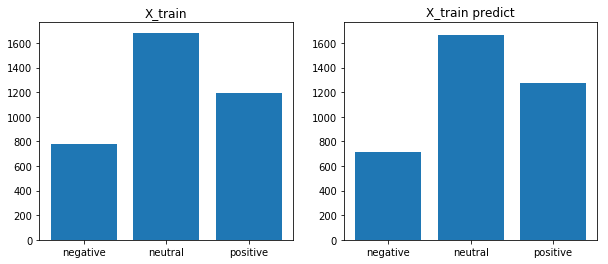

In [37]:
model_info_train(sgd_classifier, X_train, y_train, 'Stochastic Gradient Descent Classification')

****validate_set****
Model is <<Stochastic Gradient Descent Classification>>
accuracy: 0.7430340557275542
f1 score: 0.7241458763705705
recall: 0.7242491673575054
precision: 0.726685808271486


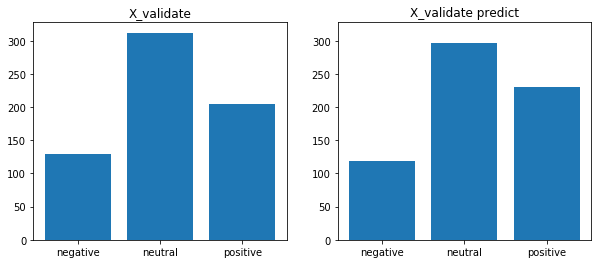

In [38]:
model_info_validation(sgd_classifier, X_test, y_test, 'Stochastic Gradient Descent Classification')


Till now the training data and testing data were from the same dataset. Now we downloaded random tweets and see how our model will perform.

# Testing on Commercial dataset 

In [39]:
dataset_test = pd.read_csv("../input/sentiment-analysis-data/commercial.csv")
dataset_test.head()

,sentiment,text,user
0,neutral,Personal or Commercial Garden? by Anne Wareham...,AnneWareham
1,neutral,"RT @narendramodi: After the SCO Summit, I shal...",DilipChowkidar
2,neutral,"RT @narendramodi: After the SCO Summit, I shal...",IMRAJRAY
3,neutral,"RT @narendramodi: After the SCO Summit, I shal...",Nikunjparekh002
4,neutral,"RT @narendramodi: After the SCO Summit, I shal...",MyNameisSVS


In [40]:
dataset_test['label'] = 0
for i in range(dataset_test.shape[0]):
    if dataset_test['sentiment'][i] == 'neutral':
        dataset_test['label'][i] = 1
    elif dataset_test['sentiment'][i] == 'positive':
        dataset_test['label'][i] = 2

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
corpus_test = []
for i in range(dataset_test.shape[0]):
    text = re.sub('[^a-zA-Z]', ' ', dataset_test['text'][i])
    text = text.lower()
    text = text.split()
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    corpus_test.append(text)

X_comm_test = tf.transform(corpus_test).toarray()
y_comm_test = dataset_test['label'].values

****test_set****
Model is <<Naive Bayes classifier>>
accuracy: 0.2631578947368421
f1 score: 0.2614202417268409
recall: 0.3492822966507177
precision: 0.37777777777777777


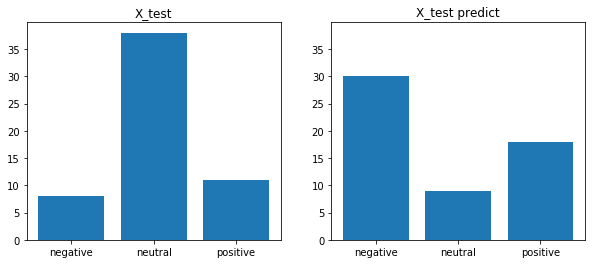

In [42]:
# naive bayes classifier
model_info_test(classifier_naive_bayes, X_comm_test, y_comm_test, 'Naive Bayes classifier')

****test_set****
Model is <<logistic classifier>>
accuracy: 0.7192982456140351
f1 score: 0.5593981077852046
recall: 0.6078548644338118
precision: 0.7777777777777778


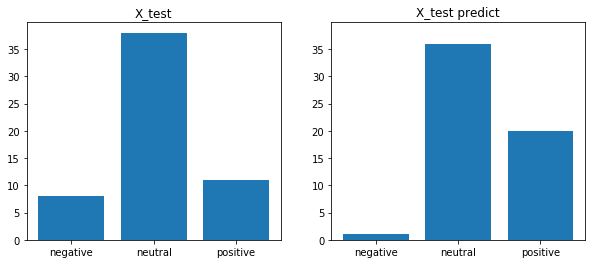

In [43]:
# logistic Regression
model_info_test(lg_classifier, X_comm_test, y_comm_test, 'logistic classifier')

****test_set****
Model is <<SVM classifier>>
accuracy: 0.5964912280701754
f1 score: 0.39493839493839494
recall: 0.39573365231259966
precision: 0.39646464646464646


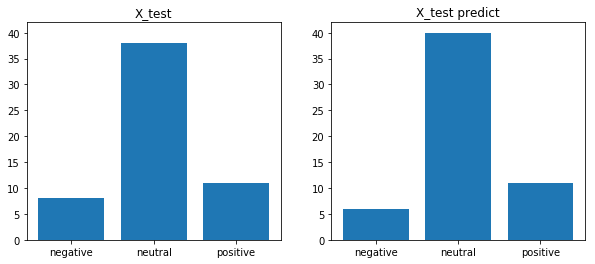

In [44]:
# SVM classifier
model_info_test(svc_classifier, X_comm_test, y_comm_test, 'SVM classifier')

****test_set****
Model is <<Decision Tree classifier>>
accuracy: 0.5087719298245614
f1 score: 0.3583333333333334
recall: 0.4481658692185008
precision: 0.3598585322723254


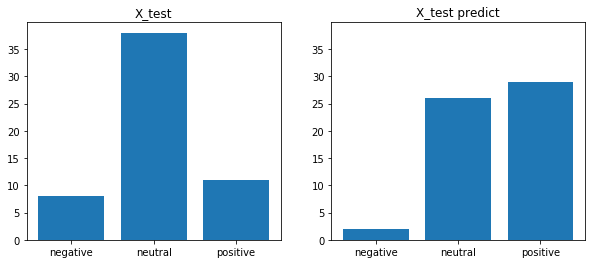

In [45]:
# Decision Tree classifier
model_info_test(dt_classifier, X_comm_test, y_comm_test, 'Decision Tree classifier')

****test_set****
Model is <<Random Forest classifier>>
accuracy: 0.6666666666666666
f1 score: 0.5152797819464486
recall: 0.5384768740031899
precision: 0.5811965811965812


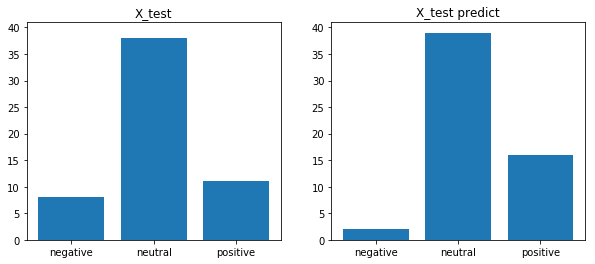

In [46]:
# Random Forest Classifier
model_info_test(rdt_classifier, X_comm_test, y_comm_test, 'Random Forest classifier')

****test_set****
Model is <<Stochastic Gradient classifier>>
accuracy: 0.6140350877192983
f1 score: 0.48483771618099974
recall: 0.5552232854864433
precision: 0.49808429118773945


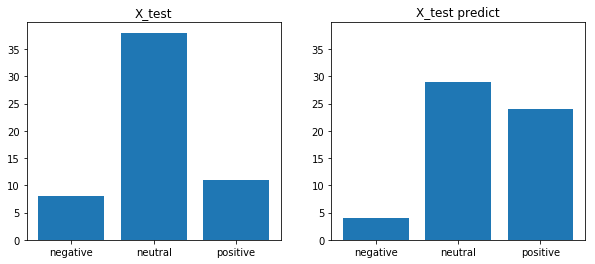

In [47]:
# Stochastic Gradient Classifier
model_info_test(sgd_classifier, X_comm_test, y_comm_test, 'Stochastic Gradient classifier')

# Simple perceptron Network

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [49]:
Y_train = pd.get_dummies(y_train).values

In [50]:
# kernel_initializerialising the ANN
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 1024,kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))

# Adding the hidden layer
classifier.add(Dense(units = 1024, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 1024, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 512, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 512, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 512, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'softmax'))

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [51]:
# Fitting the ANN to the Training set
classifier.fit(X_train, Y_train, batch_size = 16,epochs = 100, verbose = 5)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [52]:
print("***Training Set***")
y_train_pred = classifier.predict_classes(X_train)
print("accuracy score :",accuracy_score(y_train, y_train_pred))
print("precision score :",precision_score(y_train, y_train_pred, average = 'macro'))
print("recall score :",recall_score(y_train, y_train_pred, average = 'macro'))
print("f1 score :",f1_score(y_train, y_train_pred, average = 'macro'))

print("***Test Set***")
y_test_pred = classifier.predict_classes(X_test)
print("accuracy score :",accuracy_score(y_test, y_test_pred))
print("precision score :",precision_score(y_test, y_test_pred, average = 'macro'))
print("recall score :",recall_score(y_test, y_test_pred, average = 'macro'))
print("f1 score :",f1_score(y_test, y_test_pred, average = 'macro'))

***Training Set***
accuracy score : 0.9939857845817387
precision score : 0.9955236996080229
recall score : 0.9921612906483818
f1 score : 0.9938093257552457
***Test Set***
accuracy score : 0.7739938080495357
precision score : 0.7680027252394837
recall score : 0.733577550891788
f1 score : 0.7466959443486241


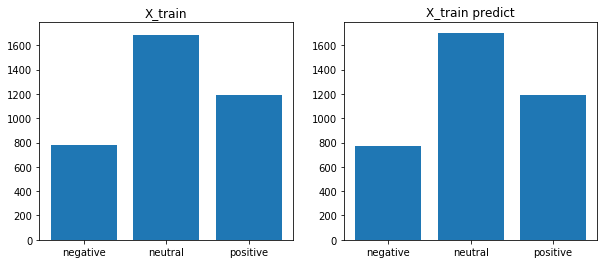

In [53]:
# plotting
plt.figure(figsize = (10,4))
ax1 = plt.subplot('121')
plt.title("X_train")
validate_freq = {}
validate_freq['positive'] = np.sum((y_train == 2)*1)
validate_freq['neutral'] = np.sum((y_train == 1)*1)
validate_freq['negative'] = np.sum((y_train == 0)*1)

lists = sorted(validate_freq.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.bar(x, y)

plt.subplot('122', sharex = ax1, sharey = ax1)
plt.title("X_train predict")
validate_pred_freq = {}
validate_pred_freq['positive'] = np.sum((y_train_pred == 2)*1)
validate_pred_freq['neutral'] = np.sum((y_train_pred == 1)*1)
validate_pred_freq['negative'] = np.sum((y_train_pred == 0)*1)

lists = sorted(validate_pred_freq.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.bar(x, y)

plt.show()

In [54]:
# On commercial dataset
print("***Commercial Test Set***")
y_comm_pred = classifier.predict_classes(X_comm_test)
print("accuracy score :",accuracy_score(y_comm_test, y_comm_pred))
print("precision score :",precision_score(y_comm_test, y_comm_pred, average = 'macro'))
print("recall score :",recall_score(y_comm_test, y_comm_pred, average = 'macro'))
print("f1 score :",f1_score(y_comm_test, y_comm_pred, average = 'macro'))

***Commercial Test Set***
accuracy score : 0.6842105263157895
precision score : 0.4549266247379455
recall score : 0.38516746411483255
f1 score : 0.36630036630036633
